## Week‑6 End‑to‑End Assignment — Adult Income Dataset
##
## **Includes**
## * Clustering: K‑Means, Hierarchical, DBSCAN, Gaussian Mixture
## * Ensembles: Bagging (Random Forest), Boosting (Gradient Boosting), Stacking
## * Regularisation: L1/L2/ElasticNet Logistic Regression
## * Baseline vs Tuned model evaluation (Accuracy, Precision, Recall, F1)
## * Hyper‑Parameter Tuning (GridSearchCV & RandomizedSearchCV)
## * Graphical comparison of metrics before and after tuning

## 1. **Imports & Global Settings**


In [1]:
import warnings, json, pprint, textwrap, itertools, math, os, sys, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from urllib.request import urlretrieve

# Scikit‑learn
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV, cross_val_score
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.stats import randint, uniform

# Visualisation
import matplotlib.pyplot as plt
plt.style.use("default")

RANDOM_STATE = 42
print("✓ Libraries imported.")


✓ Libraries imported.


## 2. Data Loading & Pre‑processing


In [2]:
DATA_URL  = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
COLS = [
    'age','workclass','fnlwgt','education','education-num','marital-status',
    'occupation','relationship','race','sex','capital-gain','capital-loss',
    'hours-per-week','native-country','income'
]

csv_path = Path("adult.csv")
if not csv_path.exists():
    urlretrieve(DATA_URL, csv_path)

adult = pd.read_csv(csv_path, names=COLS, na_values=" ?", sep=",", skipinitialspace=True)
adult.dropna(inplace=True)
adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
# Split X/y
X = adult.drop("income", axis=1)
y = (adult["income"] == ">50K").astype(int)

# Column groups
cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

preprocessor = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, stratify=y, random_state=RANDOM_STATE
)
print(f"Train : {X_train.shape}, Test : {X_test.shape}")


Train : (26048, 14), Test : (6513, 14)


# 3. Clustering Showcase (Week‑6 content)
# *Purely unsupervised; serves as demo.*


In [11]:
X_full_enc = preprocessor.fit_transform(X)         # fit on full data

print("\n🔸 K-Means")
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE).fit(X_full_enc)
print("Inertia:", kmeans.inertia_)

print("\n🔸 Hierarchical (Agglomerative)")
hc = AgglomerativeClustering(n_clusters=4)
hc_labels = hc.fit_predict(X_full_enc.toarray() if hasattr(X_full_enc, "toarray") else X_full_enc)
print("Clusters:", np.unique(hc_labels).size)

print("\n🔸 DBSCAN")
db = DBSCAN(eps=2.5, min_samples=10).fit(X_full_enc)
print("Clusters incl. noise:", np.unique(db.labels_).size)

print("\n🔸 Gaussian Mixture Model")
gmm = GaussianMixture(n_components=4, random_state=RANDOM_STATE).fit(X_full_enc.toarray() if hasattr(X_full_enc, "toarray") else X_full_enc)
print("Converged:", gmm.converged_, "n_iter:", gmm.n_iter_)



🔸 K-Means
Inertia: 259185.25042282767

🔸 Hierarchical (Agglomerative)
Clusters: 4

🔸 DBSCAN
Clusters incl. noise: 3

🔸 Gaussian Mixture Model
Converged: True n_iter: 13


## 4. Baseline Supervised Models (No Tuning)


In [12]:
def build_baseline_models():
    return {
        "LogReg-L2": Pipeline([("prep", preprocessor),
                               ("clf", LogisticRegression(max_iter=200, penalty="l2", solver="lbfgs", random_state=RANDOM_STATE))]),
        "RandomForest": Pipeline([("prep", preprocessor),
                                  ("clf", RandomForestClassifier(random_state=RANDOM_STATE))]),
        "GradBoost": Pipeline([("prep", preprocessor),
                               ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))]),
    }

def evaluate_model(name, model, X_te, y_te, store):
    y_pred = model.predict(X_te)
    store[name] = {
        "accuracy":  accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred),
        "recall":    recall_score(y_te, y_pred),
        "f1":        f1_score(y_te, y_pred),
    }
    print(f"--- {name} ---")
    print(classification_report(y_te, y_pred, digits=3))

baseline_scores = {}
baseline_models  = build_baseline_models()
for n, m in baseline_models.items():
    m.fit(X_train, y_train)
    evaluate_model(n, m, X_test, y_test, baseline_scores)

pd.DataFrame(baseline_scores).T


--- LogReg-L2 ---
              precision    recall  f1-score   support

           0      0.885     0.931     0.908      4945
           1      0.740     0.620     0.675      1568

    accuracy                          0.856      6513
   macro avg      0.813     0.775     0.791      6513
weighted avg      0.850     0.856     0.851      6513

--- RandomForest ---
              precision    recall  f1-score   support

           0      0.889     0.927     0.908      4945
           1      0.735     0.636     0.682      1568

    accuracy                          0.857      6513
   macro avg      0.812     0.782     0.795      6513
weighted avg      0.852     0.857     0.854      6513

--- GradBoost ---
              precision    recall  f1-score   support

           0      0.888     0.947     0.917      4945
           1      0.788     0.624     0.696      1568

    accuracy                          0.869      6513
   macro avg      0.838     0.785     0.806      6513
weighted avg     

,accuracy,precision,recall,f1
LogReg-L2,0.855980,0.739726,0.619898,0.674532
RandomForest,0.857209,0.734904,0.636480,0.682160
GradBoost,0.869031,0.788074,0.623724,0.696333


## 5. Hyper‑Parameter Tuning


In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Logistic Regression with L1, L2, ElasticNet
log_pipe = Pipeline([("prep", preprocessor),
                     ("clf", LogisticRegression(max_iter=200, solver="saga", random_state=RANDOM_STATE))])
param_grid_lr = {
    "clf__penalty": ["l1", "l2", "elasticnet"],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__l1_ratio": [None, 0.5, 0.7]  # only used for elasticnet
}
grid_lr = GridSearchCV(log_pipe, param_grid_lr, cv=cv, scoring="f1", n_jobs=-1)

# Random Forest – RandomizedSearchCV
rf_pipe = Pipeline([("prep", preprocessor),
                    ("clf", RandomForestClassifier(random_state=RANDOM_STATE))])
param_dist_rf = {
    "clf__n_estimators": randint(200, 500),
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_split": randint(2, 10),
    "clf__min_samples_leaf": randint(1, 5)
}
rand_rf = RandomizedSearchCV(rf_pipe, param_dist_rf, n_iter=25, cv=cv,
                             scoring="f1", random_state=RANDOM_STATE, n_jobs=-1)

# Gradient Boosting – GridSearchCV
gb_pipe = Pipeline([("prep", preprocessor),
                    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))])
param_grid_gb = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 4]
}
grid_gb = GridSearchCV(gb_pipe, param_grid_gb, cv=cv, scoring="f1", n_jobs=-1)

tuned_searches = {
    "LogReg-Tuned": grid_lr,
    "RandomForest-Tuned": rand_rf,
    "GradBoost-Tuned": grid_gb,
}

# Fit searches
for name, search in tuned_searches.items():
    print(f"⏳ Tuning {name} …")
    search.fit(X_train, y_train)
    print("   best F1:", search.best_score_, "params:", search.best_params_)


⏳ Tuning LogReg-Tuned …
   best F1: 0.6577805540842714 params: {'clf__C': 1, 'clf__l1_ratio': None, 'clf__penalty': 'l2'}
⏳ Tuning RandomForest-Tuned …
   best F1: 0.6848058186571963 params: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 9, 'clf__n_estimators': 493}
⏳ Tuning GradBoost-Tuned …
   best F1: 0.7113470319450148 params: {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 200}


In [15]:
# Evaluate tuned models on test set
tuned_scores = {}
for name, search in tuned_searches.items():
    best_model = search.best_estimator_
    evaluate_model(name, best_model, X_test, y_test, tuned_scores)

pd.DataFrame(tuned_scores).T


--- LogReg-Tuned ---
              precision    recall  f1-score   support

           0      0.885     0.931     0.908      4945
           1      0.740     0.620     0.675      1568

    accuracy                          0.856      6513
   macro avg      0.813     0.775     0.791      6513
weighted avg      0.850     0.856     0.851      6513

--- RandomForest-Tuned ---
              precision    recall  f1-score   support

           0      0.891     0.944     0.917      4945
           1      0.782     0.635     0.701      1568

    accuracy                          0.869      6513
   macro avg      0.836     0.789     0.809      6513
weighted avg      0.865     0.869     0.865      6513

--- GradBoost-Tuned ---
              precision    recall  f1-score   support

           0      0.898     0.943     0.920      4945
           1      0.787     0.663     0.719      1568

    accuracy                          0.875      6513
   macro avg      0.842     0.803     0.820      6513
we

,accuracy,precision,recall,f1
LogReg-Tuned,0.855980,0.739726,0.619898,0.674532
RandomForest-Tuned,0.869492,0.782233,0.634566,0.700704
GradBoost-Tuned,0.875480,0.786525,0.662628,0.719280


## 6. Stacking Ensemble (Meta‑model)


In [17]:
stack = StackingClassifier(
    estimators=[
        ("lr", tuned_searches["LogReg-Tuned"].best_estimator_),
        ("rf", tuned_searches["RandomForest-Tuned"].best_estimator_),
    ],
    final_estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    cv=cv, n_jobs=-1
)
stack.fit(X_train, y_train)
stack_scores = {}
evaluate_model("Stacking", stack, X_test, y_test, stack_scores)


--- Stacking ---
              precision    recall  f1-score   support

           0      0.892     0.941     0.916      4945
           1      0.774     0.640     0.701      1568

    accuracy                          0.868      6513
   macro avg      0.833     0.791     0.808      6513
weighted avg      0.864     0.868     0.864      6513



## 7. Combine & Plot Baseline vs Tuned Scores


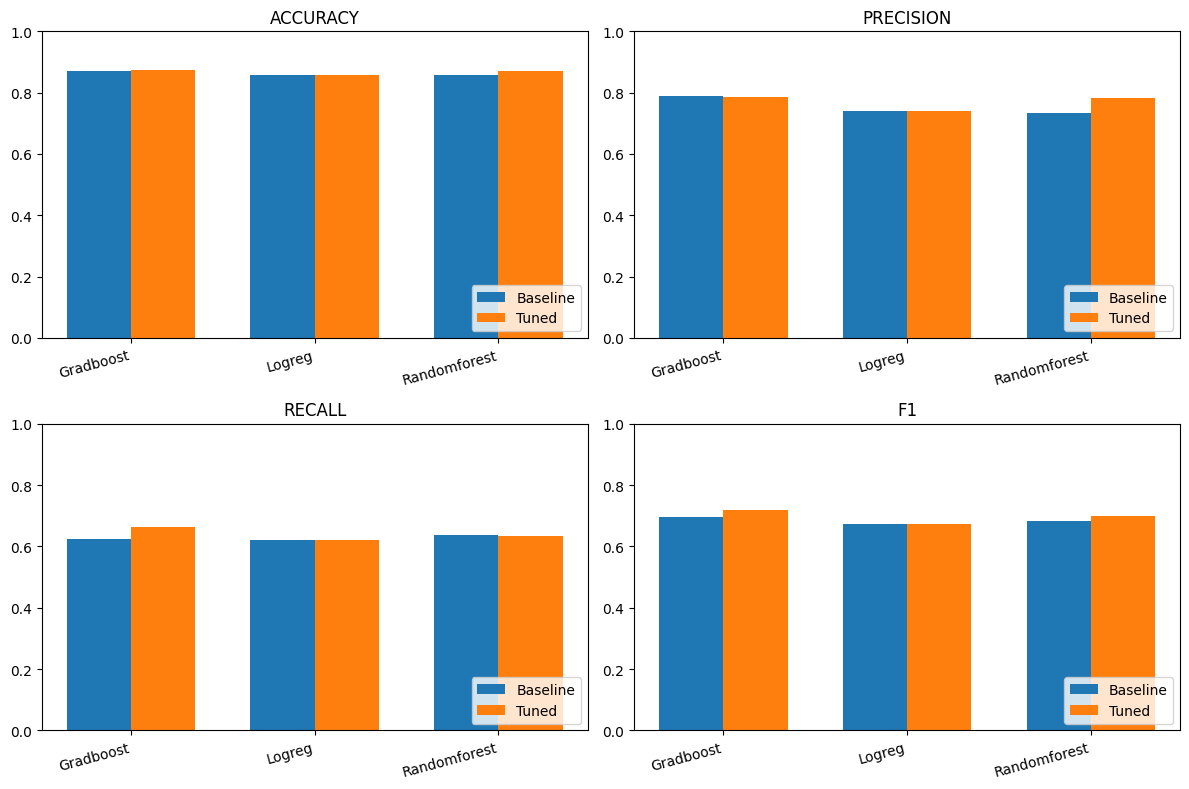

In [27]:
import re
display_cols = ["accuracy", "precision", "recall", "f1"]

def root(name: str) -> str:
    name = name.replace("‑", "-")
    return re.split(r"[-_]", name)[0].lower()

base_map  = {root(i): i for i in baseline_df.index}
tuned_map = {root(i): i for i in tuned_df.index}
common_roots = sorted(set(base_map) & set(tuned_map))

baseline_plot = baseline_df.loc[[base_map[r] for r in common_roots], display_cols]
tuned_plot    = tuned_df.loc[[tuned_map[r]  for r in common_roots], display_cols]
labels = [r.title() for r in common_roots]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
width = 0.35
ind   = np.arange(len(common_roots))

for i, metric in enumerate(display_cols):
    ax = axes[i]
    ax.bar(ind - width/2, baseline_plot[metric], width, label="Baseline")
    ax.bar(ind + width/2, tuned_plot[metric],   width, label="Tuned")
    ax.set_title(metric.upper())
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, rotation=15, ha="right")
    ax.set_ylim(0, 1)
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


## 8. Summary Table


In [23]:
final_df = tuned_df[display_cols].copy()
final_df.loc["Stacking"] = stack_scores["Stacking"]
final_df = final_df.sort_values("f1", ascending=False)
final_df.style.format("{:.3f}")


,accuracy,precision,recall,f1
GradBoost-Tuned,0.875,0.787,0.663,0.719
Stacking,0.868,0.774,0.640,0.701
RandomForest-Tuned,0.869,0.782,0.635,0.701
LogReg-Tuned,0.856,0.740,0.620,0.675
